In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

In [101]:
data = pd.read_csv('data/train_val_split.csv')
test_data = pd.read_csv('data/test_split.csv')

In [81]:
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,M,ATA,120,157,0,Normal,182,N,0.0,Up,0
730,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
731,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
732,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1


# Data Exploration

In [29]:
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [12]:
data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [9]:
#describtion of numeric columns
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,734.000000,734.00000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,53.523161,132.06267,197.588556,0.232970,136.167575,0.873978,0.542234
std,9.421110,18.61849,108.979439,0.423012,25.334552,1.082222,0.498553
min,29.000000,0.00000,0.000000,0.000000,60.000000,-2.000000,0.000000
25%,47.000000,120.00000,172.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.00000,222.000000,0.000000,138.000000,0.500000,1.000000
75%,60.000000,140.00000,267.000000,0.000000,155.000000,1.500000,1.000000
max,77.000000,200.00000,529.000000,1.000000,195.000000,6.200000,1.000000


In [64]:
numeric_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [15]:
data.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

the dataset is balanced. about half of the attributes are non-numerical. No NaN in dataset

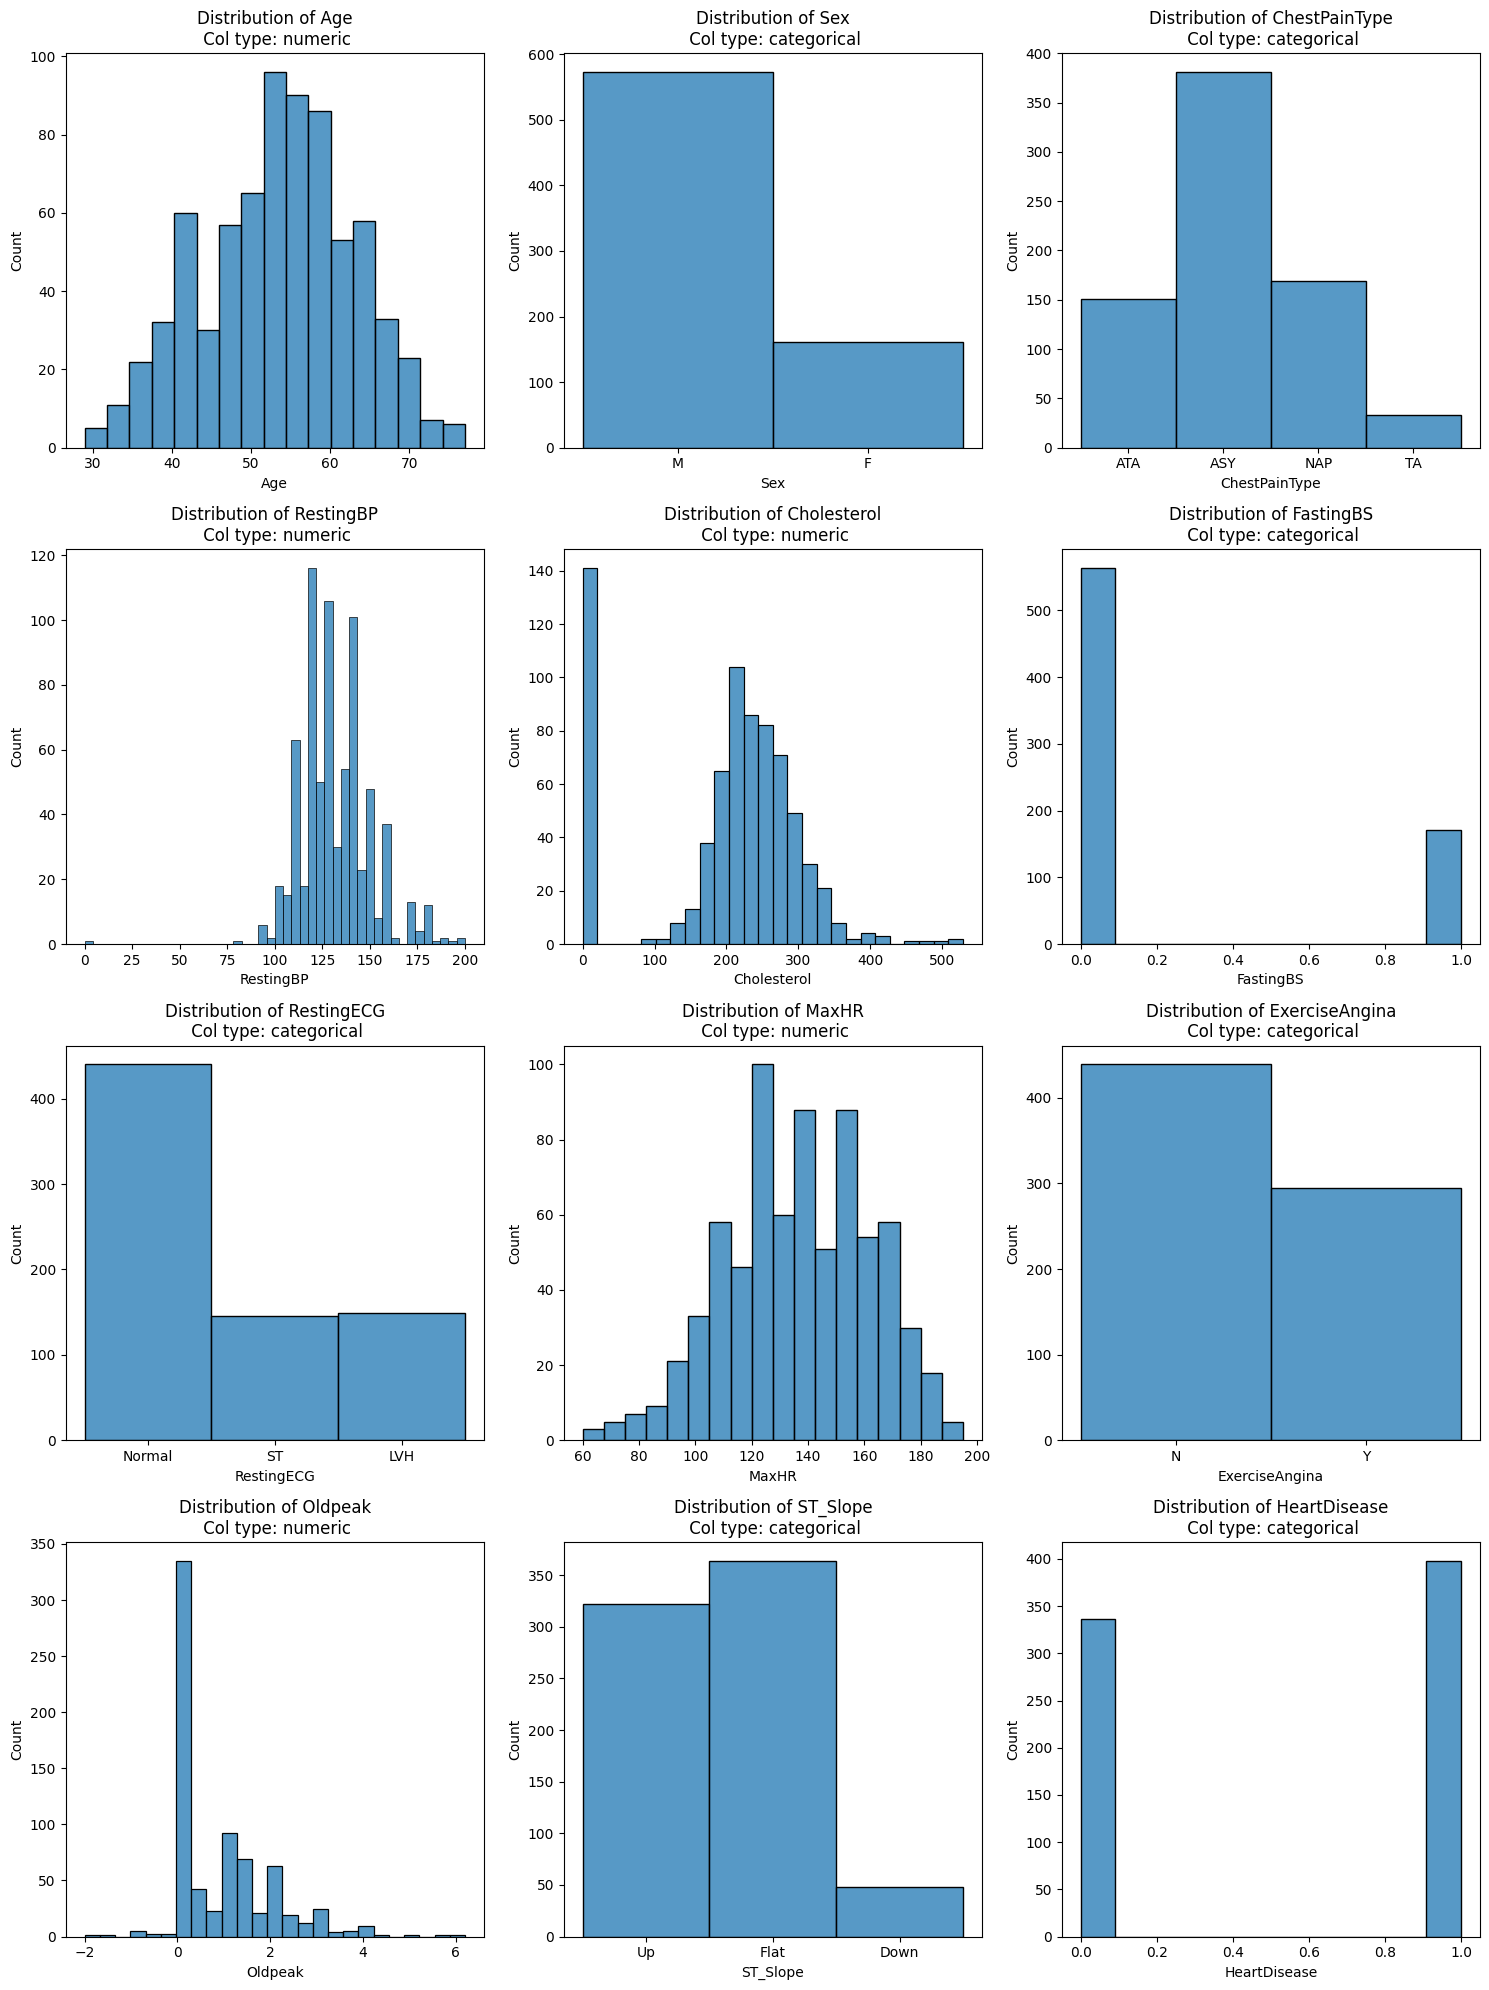

In [65]:
# Plot distributions for train set
columns = data.columns
n_cols = len(columns)
n_rows = (n_cols + 2) // 3  # Ensure we have enough rows to show all variables

fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axes = axes.ravel()

for idx, col in enumerate(columns):
    valid_data = data[col]
    sns.histplot(data=valid_data, ax=axes[idx])
    column_type = 'numeric' if col in numeric_columns else 'categorical'
    axes[idx].set_title(f'Distribution of {col}\n Col type: {column_type}')
    
plt.tight_layout()
plt.show()

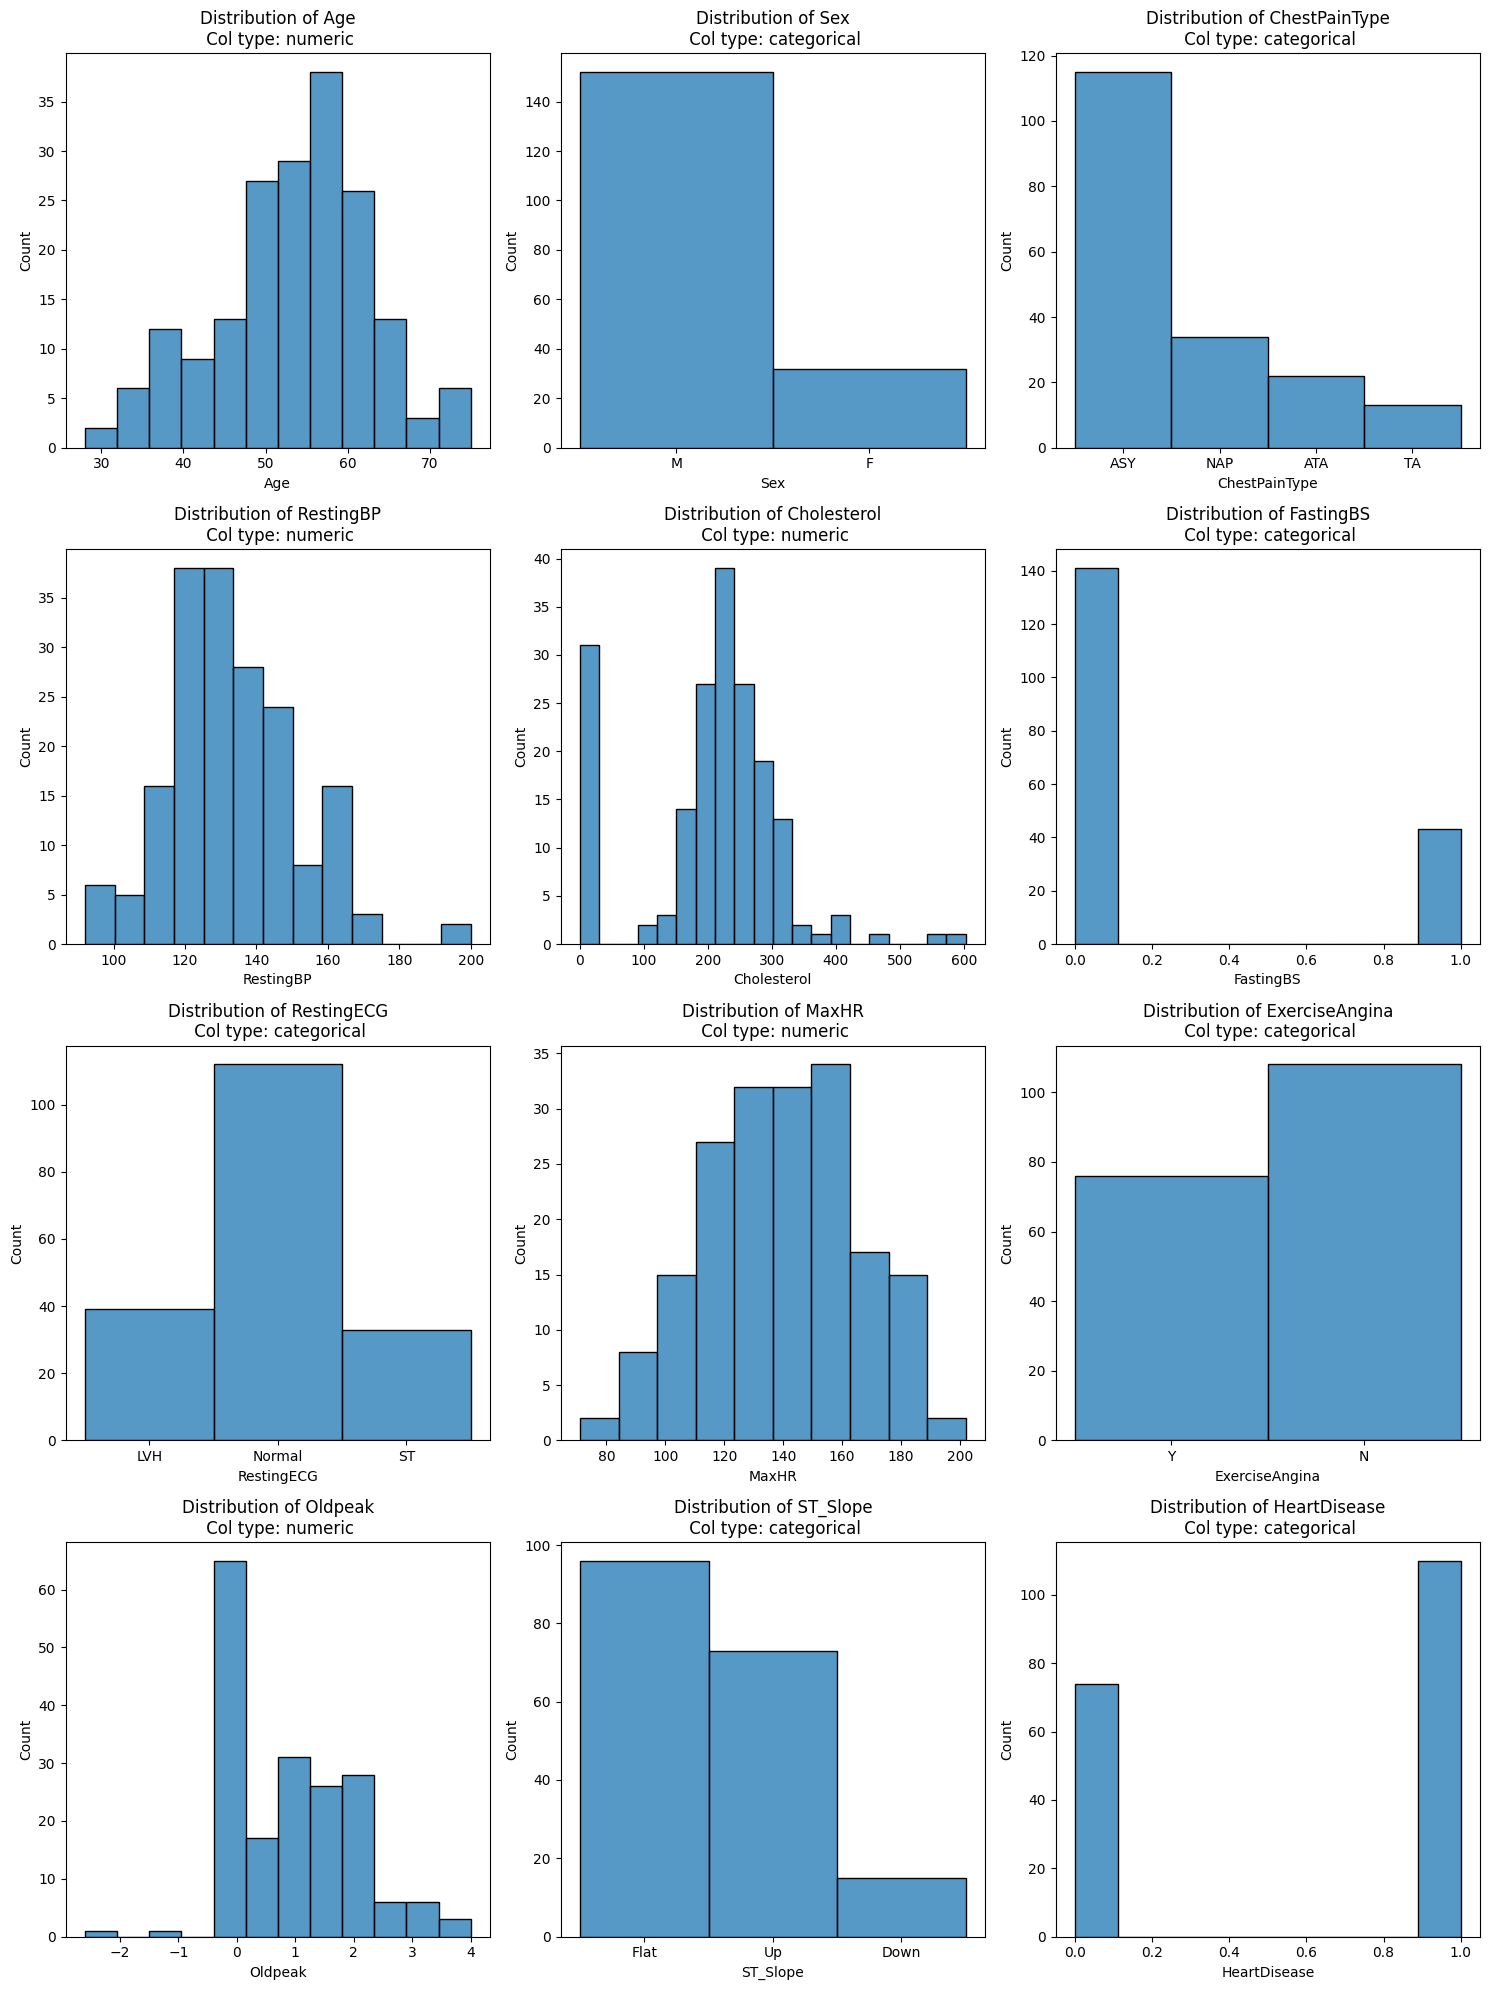

In [6]:
# Plot distributions for test set
columns = test_data.columns
n_cols = len(columns)
n_rows = (n_cols + 2) // 3  # Ensure we have enough rows to show all variables

fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axes = axes.ravel()

for idx, col in enumerate(columns):
    valid_data = test_data[col]
    sns.histplot(data=valid_data, ax=axes[idx])
    column_type = 'numeric' if col in numeric_columns else 'categorical'
    axes[idx].set_title(f'Distribution of {col}\n Col type: {column_type}')
    
plt.tight_layout()
plt.show()

All numeric data seems Gaussian. Nans for most numeric attibutes seems to be encoded as 0. Categorical attibutes are not balanced execpt for heart disease, and not imbalanced the same way in both sets.

# Preprocessing

In [92]:
#column to encode as 0/1
col_to_bin = ['Sex']
#column to one-hot encode
col_to_ohe = ['ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [93]:
def preprocessing_categorical(data):
    #make all data numeric for downstream tasks
    for col in col_to_bin:
        label_encoder = LabelEncoder()
        data[col] = label_encoder.fit_transform(data[col])
    data = pd.get_dummies(data, columns=[c for c in col_to_ohe])
    return data

In [102]:
outcome = data['HeartDisease']   
data = data.drop('HeartDisease', axis=1)           
outcome_test = test_data['HeartDisease'] 
test_data = test_data.drop('HeartDisease', axis=1) 

In [103]:
data_preprocessed = preprocessing_categorical(data)
test_data_preprocessed = preprocessing_categorical(test_data)


In [96]:
zero_missing_cols = ['Cholesterol', 'Oldpeak']

def knn_fill_zeros(df, n_neighbors=15):
    df_filled = df.copy()
    df_for_knn = df.copy()
    df_for_knn[zero_missing_cols] = df_for_knn[zero_missing_cols].replace(0, np.nan)
    df_for_knn = df_for_knn.fillna(df.mean())
    knn = NearestNeighbors(n_neighbors=n_neighbors + 1)  # +1 because first neighbor is the point itself
    knn.fit(df_for_knn.fillna(df.mean()))  # use mean-filled data for distance calc

    for col in zero_missing_cols:
        zero_indices = df[df[col] == 0].index
        for idx in zero_indices:
            # Find neighbors of the point
            point = df.loc[idx].values.reshape(1, -1)
            distances, indices = knn.kneighbors(point)

            # Find the nearest neighbor that has a non-zero value for this column
            for neighbor_idx in indices[0][1:]:  # skip first (itself)
                neighbor_value = df.loc[neighbor_idx, col]
                if neighbor_value != 0:
                    df_filled.loc[idx, col] = neighbor_value
                    break  # stop after first valid neighbor
    return df_filled

In [104]:
data_preprocessed = knn_fill_zeros(data_preprocessed)
test_data_preprocessed = knn_fill_zeros(test_data_preprocessed)

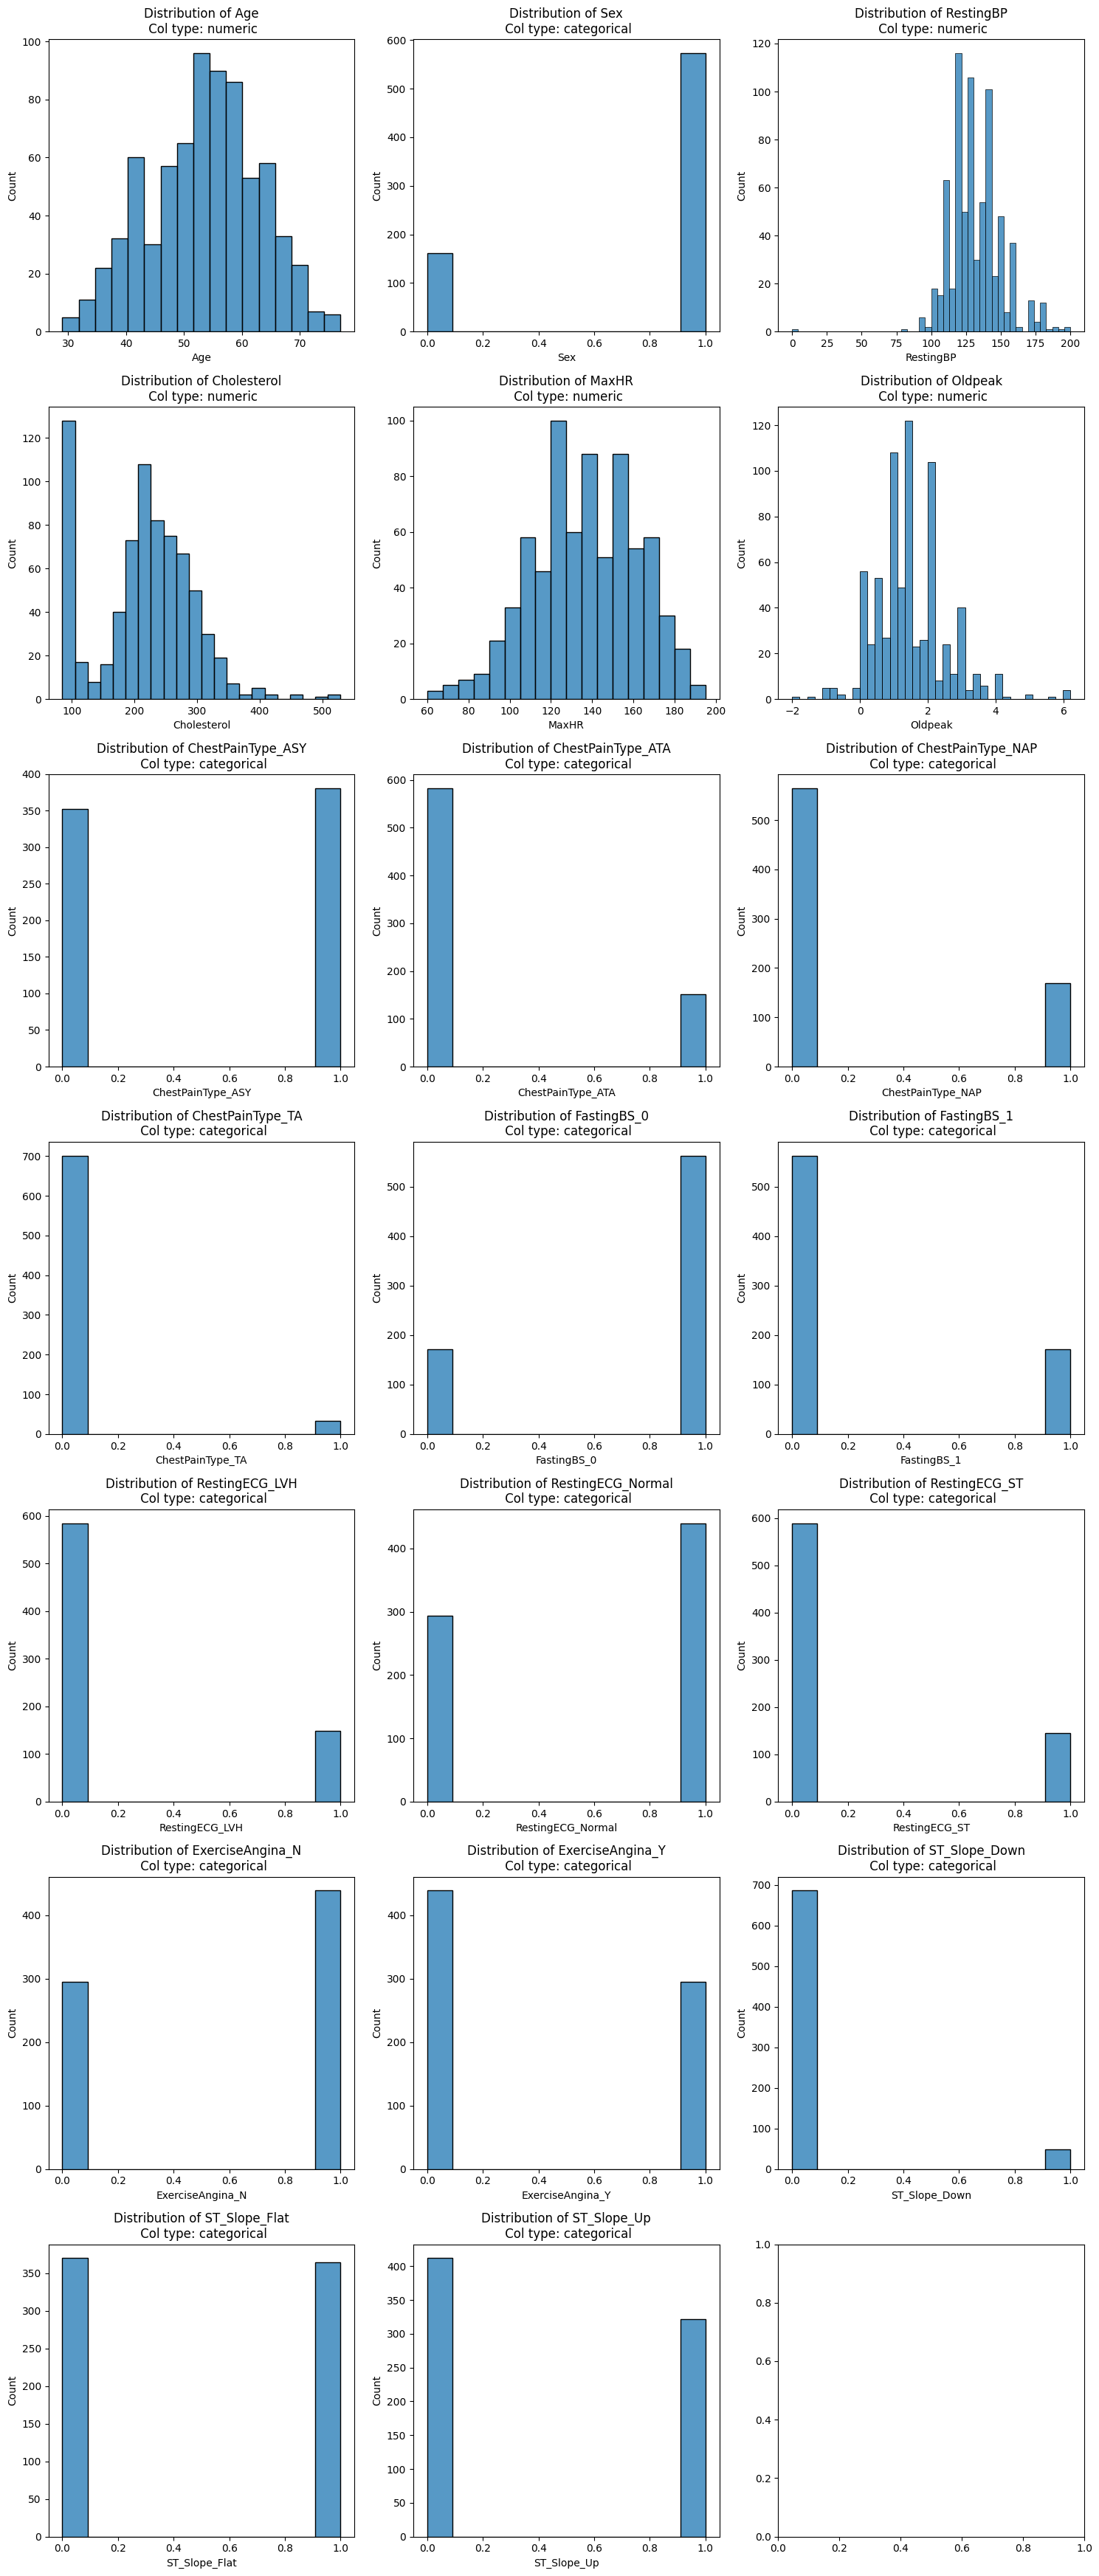

In [105]:
# Plot distributions for train set
columns = data_preprocessed.columns
n_cols = len(columns)
n_rows = (n_cols + 2) // 3  # Ensure we have enough rows to show all variables

fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axes = axes.ravel()

for idx, col in enumerate(columns):
    valid_data = data_preprocessed[col]
    sns.histplot(data=valid_data, ax=axes[idx])
    column_type = 'numeric' if col in numeric_columns else 'categorical'
    axes[idx].set_title(f'Distribution of {col}\n Col type: {column_type}')
    
plt.tight_layout()
plt.show()

In [98]:
data_preprocessed

,Age,Sex,RestingBP,Cholesterol,MaxHR,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_0,FastingBS_1,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,172,2.0,False,True,False,False,True,False,False,True,False,True,False,False,False,True
1,37,1,130,283,98,2.0,False,True,False,False,True,False,False,False,True,True,False,False,False,True
2,48,0,138,214,108,1.5,True,False,False,False,True,False,False,True,False,False,True,False,True,False
3,54,1,150,195,122,0.5,False,False,True,False,True,False,False,True,False,True,False,False,False,True
4,39,1,120,339,170,1.0,False,False,True,False,True,False,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,1,120,157,182,0.6,False,True,False,False,True,False,False,True,False,True,False,False,False,True
730,57,0,140,241,123,0.2,True,False,False,False,True,False,False,True,False,False,True,False,True,False
731,45,1,110,264,132,1.2,False,False,False,True,True,False,False,True,False,True,False,False,True,False
732,68,1,144,193,141,3.4,True,False,False,False,False,True,False,True,False,True,False,False,True,False


In [99]:
scaler = StandardScaler()
scaled_data  = scaler.fit_transform(data_preprocessed)
data_preprocessed = pd.DataFrame(scaled_data, columns=data_preprocessed.columns, index=data_preprocessed.index)
scaled_data = scaler.transform(test_data_preprocessed)
test_data_preprocessed = pd.DataFrame(scaled_data, columns=test_data_preprocessed.columns, index=test_data_preprocessed.index)

data_preprocessed.to_csv('data/data_preprocessed.csv')
test_data_preprocessed.to_csv('data/test_data_preprocessed.csv')
outcome.to_csv('data/outcome.csv')
outcome_test.to_csv('data/outcome_test.csv')